# Plagiarism Detection

In [ ]:
import os
import numpy as np
import gensim.downloader as api
import zipfile
import kagglehub
import nltk
import pandas as pd
from nltk.corpus import stopwords
from collections import defaultdict


## 1. Exploring the Dataset  
Download the data, unzip it. The directory is `data`

In [41]:
data_url = "https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c4147f9_data/data.zip"
data_path = "data.zip"

if not os.path.exists("data"):
    response = requests.get(data_url)
    with open(data_path, "wb") as f:
        f.write(response.content)
    with zipfile.ZipFile(data_path, "r") as zip_ref:
        zip_ref.extractall()


Using api to load the model `word2vec`

In [42]:
word2vec_model = api.load("word2vec-google-news-300")


## 2. Build a class for computing document similarity (`DocSim` class)


In [43]:
class DocSim:
    def __init__(self, model, stopwords=STOPWORDS):
        self.model = model
        self.stopwords = stopwords
    
    def vectorize(self, text):
        words = [word for word in text.lower().split() if word not in self.stopwords]
        word_vectors = [self.model[word] for word in words if word in self.model]
        return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(300)
    
    def similarity(self, text1, text2):
        vec1 = self.vectorize(text1)
        vec2 = self.vectorize(text2)
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


## 3. Create an instance of the above class (Load the pre-trained word embedding model, Create a list of stopwords and create an instance of the `DocSim` class)


In [44]:
doc_sim = DocSim(word2vec_model)
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 4. Plagiarism Detection and Evaluation


Load all `.txt` file from the directory `data`. Group them based on their task to compare with its original text

In [45]:
file_data = pd.read_csv("data/file_information.csv")
files_by_task = defaultdict(list)
for _, row in file_data.iterrows():
    file_name, task, category = row["File"], row["Task"], row["Category"]
    files_by_task[task].append((file_name, category))


In [46]:
def read_file_content(file_name):
    file_path = os.path.join("data", file_name)  
    try:
        with open(file_path, "r", encoding="utf-8") as file:
            return file.read()
    except UnicodeDecodeError:
        try:
            with open(file_path, "r", encoding="ISO-8859-1") as file:
                return file.read()
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            return ""



Read each `.txt` and compute similarity score using `DocSim`

In [47]:
similarity_results = {}
for task, files in files_by_task.items():
    orig_file = next((f for f, c in files if c == 'orig'), None)
    if not orig_file:
        continue
    orig_text = read_file_content(orig_file)
    for file_name, category in files:
        if file_name == orig_file:
            continue
        text = read_file_content(file_name)
        similarity_score = doc_sim.similarity(text, orig_text)
        similarity_results[file_name] = similarity_score



In [48]:
# Check similarity score of each .txt file
for file, score in similarity_results.items():
    print(f"Similarity Score for {file}: {score}")

Similarity Score for g0pA_taska.txt: 0.870093584060669
Similarity Score for g0pB_taska.txt: 0.8094625473022461
Similarity Score for g0pC_taska.txt: 0.9185640215873718
Similarity Score for g0pD_taska.txt: 0.9659775495529175
Similarity Score for g0pE_taska.txt: 0.9979899525642395
Similarity Score for g1pA_taska.txt: 0.8609130382537842
Similarity Score for g1pB_taska.txt: 0.8283300995826721
Similarity Score for g1pD_taska.txt: 0.9604145884513855
Similarity Score for g2pA_taska.txt: 0.8464297652244568
Similarity Score for g2pB_taska.txt: 0.8507804274559021
Similarity Score for g2pC_taska.txt: 0.957662045955658
Similarity Score for g2pE_taska.txt: 0.9752243161201477
Similarity Score for g3pA_taska.txt: 0.8792639374732971
Similarity Score for g3pB_taska.txt: 0.8924782872200012
Similarity Score for g3pC_taska.txt: 0.9269084930419922
Similarity Score for g4pB_taska.txt: 0.8501298427581787
Similarity Score for g4pC_taska.txt: 0.9971052408218384
Similarity Score for g4pD_taska.txt: 0.95749378204

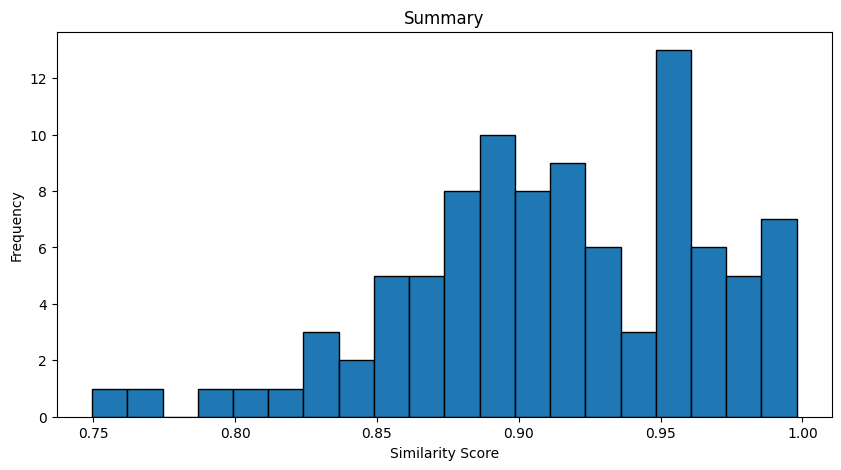

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(similarity_results.values(), bins=20, edgecolor='black')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Summary')
plt.show()
